In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from datasets import load_dataset
from jpeg.DiffJPEG import DiffJPEG
from PIL import Image
from transformers import ConvNextForImageClassification, ConvNextImageProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
def pytorch_jpeg_compress(img_tensor):
    quality = np.random.randint(50, 90)
    img = Image.fromarray(
        (
            np.clip(img_tensor.cpu().numpy().swapaxes(0, 1).swapaxes(1, 2), 0, 1) * 255
        ).astype(np.uint8)
    )

    with io.BytesIO() as f:
        img.save(f, "JPEG", quality=quality)
        img = Image.open(io.BytesIO(f.getvalue()))

    out_tensor = torch.tensor(
        np.array(img).swapaxes(2, 1).swapaxes(1, 0) / 255,
        device=img_tensor.device,
        dtype=torch.float32,
    )
    return out_tensor

def img_to_tensor(img):
    img = T.ToTensor()(img)
    return img.unsqueeze(0)

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize(img):
    return T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])(img)

def tensor_to_img(img_tensor):
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.squeeze(0)
    img = img_tensor.detach().cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
    img = np.clip(img, 0, 1)
    return Image.fromarray((img * 255).astype(np.uint8))

def differentiable_jpeg(img_tensor, quality, device=device):
    _, _, h, w = img_tensor.shape
    return DiffJPEG(quality=quality, height=h, width=w, device=device)(img_tensor)

random_crop = T.RandomResizedCrop(384, antialias=True)

In [4]:
processor = ConvNextImageProcessor.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache")
HFmodel = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache").eval()
model = next(HFmodel.modules()).to(device)

dataset = load_dataset("huggingface/cats-image", cache_dir="./cache", trust_remote_code=True)
img_original = np.array(dataset["test"]["image"][0])
img_original_tensor = img_to_tensor(Image.fromarray(img_original)).to(device)

In [5]:
n_iterations = 100
target_output = torch.tensor([383], dtype=torch.long, device=device) # do the same for 383 - 388
eps = 8. / 255. # perturbation size, set lower than needed for rounding errors
bs = 8 # batch size - not really needed, but stabilizes training and improves convergence & consistency of adversarial examples

x = img_original_tensor.clone()
x.requires_grad = True

optimizer = torch.optim.Adam([x], lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

def forward(x):
    x = differentiable_jpeg(x, random.randint(50, 90))
    x = normalize(x)
    x = random_crop(x)
    x = model(x).logits
    return x

for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    logits = forward(torch.cat([x] * bs, dim=0)) # helps as each forward pass is different, helps stabilize training
    loss = loss_func(logits, torch.cat([target_output] * bs, dim=0))
    loss.backward()

    optimizer.step()

    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if iteration % (n_iterations // 10) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(np.array(current_img).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        prediction_idx = torch.argmax(logits).item()
        prediction_prob = torch.nn.functional.softmax(logits, dim=1)[0, prediction_idx].item() * 100

        print(
            f"Iteration: {iteration: <3} | Loss: {loss.item(): .4f} | Prediction: {prediction_idx} ({prediction_prob:.2f}%) | "
            f"Min diff: {min_d: .2f} | Mean diff: {mean_d: .2f} | Max diff: {max_d: .2f}"
        )

Iteration: 0   | Loss:  8.5492 | Prediction: 281 (54.20%) | Min diff:  0.00 | Mean diff:  1.44 | Max diff:  3.00
Iteration: 10  | Loss:  0.2814 | Prediction: 383 (75.48%) | Min diff:  0.00 | Mean diff:  5.35 | Max diff:  9.00
Iteration: 20  | Loss:  0.1829 | Prediction: 383 (83.29%) | Min diff:  0.00 | Mean diff:  6.10 | Max diff:  9.00
Iteration: 30  | Loss:  0.1846 | Prediction: 383 (83.14%) | Min diff:  0.00 | Mean diff:  6.17 | Max diff:  9.00
Iteration: 40  | Loss:  0.4610 | Prediction: 383 (63.07%) | Min diff:  0.00 | Mean diff:  6.03 | Max diff:  9.00
Iteration: 50  | Loss:  0.1374 | Prediction: 383 (87.16%) | Min diff:  0.00 | Mean diff:  6.14 | Max diff:  9.00
Iteration: 60  | Loss:  0.0971 | Prediction: 383 (90.75%) | Min diff:  0.00 | Mean diff:  6.16 | Max diff:  9.00
Iteration: 70  | Loss:  0.1287 | Prediction: 383 (87.92%) | Min diff:  0.00 | Mean diff:  6.10 | Max diff:  9.00
Iteration: 80  | Loss:  0.0444 | Prediction: 383 (95.66%) | Min diff:  0.00 | Mean diff:  6.07 |

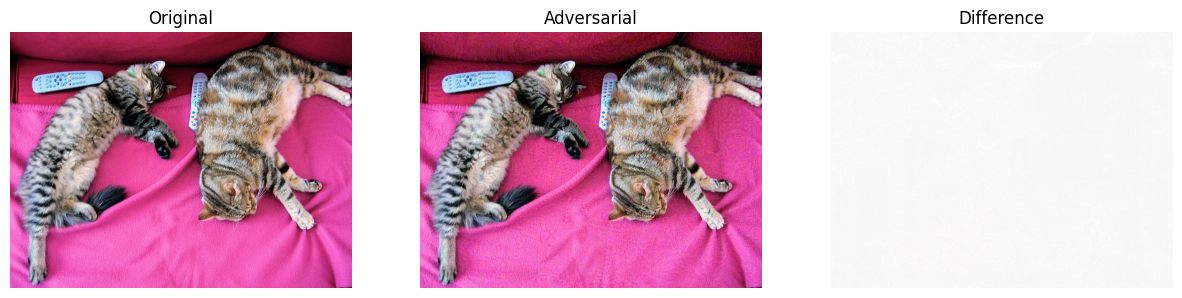

In [6]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original", "Adversarial", "Difference"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()